Isotopic stuff is here
/Users/bpb/Data/programming/computationalChem/notebooks


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
import requests, json
import numpy as np
from scipy.signal import medfilt2d
import sys
import os
sys.path.append('/Users/bpb/Data/programming/OpenMSI/openmsi-programmatic-access')
import openmsi

[ 523.565  524.565  525.57   526.575  527.575  528.58   529.585  530.585
  531.59   532.595  533.595  535.565  536.565  537.57   538.575  539.575
  540.58   541.585  542.585  543.59   544.595  545.595  546.61   547.61
  575.595  576.6    577.6    578.605  579.61   580.61   581.615  582.62
  583.62   584.625  585.63   586.63   587.645  588.645]


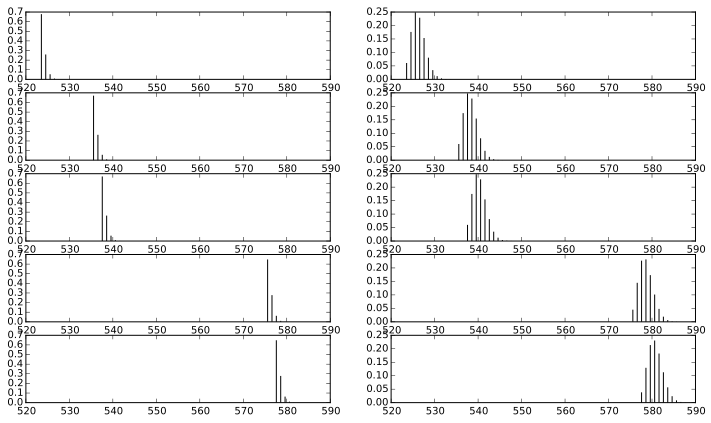

In [2]:
# openmsi = reload(openmsi)
# from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# generate a pattern
# returns an m/z vector accurate mass
# returns a natural isotopic abundance intensity
# returns a enriched isotopic abundance intensity for a given n and f
# [H, C, N, O, S, P, D, MassRemoved]
fList = [[63, 33, 0, 4, 0, 0, 0, 0],[63, 34, 0, 4, 0, 0, 0, 0],[65, 34, 0, 4, 0, 0, 0, 0],[67, 37, 0, 4, 0, 0, 0, 0],[69, 37, 0, 4, 0, 0, 0, 0]]
mzvec,isoY = openmsi.isotopic_pattern(fList, 0.08, [29,29,29, 32, 34])
mzvec = mzvec + 0.09
print mzvec


plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
for i in range(isoY.shape[0]):
    plt.subplot(5,2,i+1).vlines(mzvec,0,isoY[i,:])
    # plt.subplot(1,2,2).vlines(mzvec,0,isoY[1])
plt.show()

In [3]:
client = requests.Session()
client = openmsi.authenticateUser(client,'bpb')


········


In [4]:
filename = '/project/projectdirs/openmsi/omsi_data_private/bpb/20141025_KBL_StampA_P2_MR1_RCH2_LB_circle_100SS.h5'
# filename = '2012_0403_KBL_platename.h5'
dataIndex = '0'
expIndex = '0'
payload = {'file':filename,
          'expIndex':expIndex,'dataIndex':dataIndex,'qspectrum_viewerOption':'0',
          'qslice_viewerOption':'0',
          'col':0,'row':0,
          'findPeak':'0','format':'JSON'}
url = 'https://openmsi.nersc.gov/openmsi/qmz'
r = client.get(url,params=payload)
data = json.loads(r.content)
mz = np.asarray(data[u'values_spectra'])
print mz

[   49.969841      49.97362137    49.97739792 ...,  1303.53149414
  1303.55078125  1303.57006836]


In [5]:
nRows = 222
nCols = 244
# nRows = 250
# nCols = 160

I = np.zeros((nRows,nCols,len(mzvec)))
alldata = []
for i in range(len(mzvec)):
    idx = np.where(abs(mz - mzvec[i])<0.2)
    payload = {'file':filename,
               'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
    url = 'https://openmsi.nersc.gov/openmsi/qcube'
    r = client.get(url,params=payload)
    data = np.asarray(json.loads(r.content))
    I[:,:,i] = np.max(data,2)
    alldata.append(data)

38
[ 523.565  524.565  525.57   526.575  527.575  528.58   529.585  530.585
  531.59   532.595  533.595  535.565  536.565  537.57   538.575  539.575
  540.58   541.585  542.585  543.59   544.595  545.595  546.61   547.61
  575.595  576.6    577.6    578.605  579.61   580.61   581.615  582.62
  583.62   584.625  585.63   586.63   587.645  588.645]
(222, 244, 32)
[[12 14 16 ...,  9 20  7]
 [12 18 18 ..., 10 23 25]
 [ 6 10  4 ..., 25 28 17]
 ..., 
 [23  0 20 ...,  3  4  6]
 [ 4 16 10 ...,  3  4 11]
 [ 2  7  9 ..., 12  9 12]]


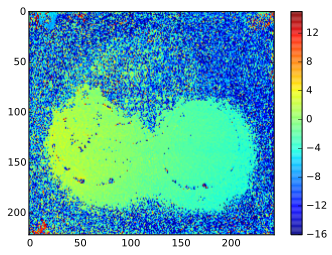

In [6]:
print len(alldata)
print mzvec
idx = np.argmax(alldata[0],2)
print alldata[0].shape
print idx
plt.imshow(idx-16)
plt.colorbar()
plt.show()
for iii in range(len(alldata)):
    idx = np.argmax(alldata[iii],2)
    for i in range(nRows):
        for j in range(nCols):
            if abs(idx[i,j]-16)>4:
                I[i,j,iii] = 0
            if i < 5:
                I[i,j,iii] = 0

[ 1200.99192281     0.           123.23390263     0.           140.26677465
    52.21911573    26.87225326     0.             0.            36.9190533 ]


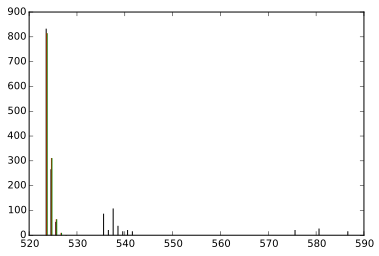

In [7]:
from scipy.optimize import nnls
# A = I[91,173,:]
A = I[135,169,:]
# A = I[0,0,:]
plt.vlines(mzvec,0,A)
x,err = nnls(np.transpose(isoY),A)
print x
plt.vlines(mzvec+0.1,0,x[0]*isoY[0] + x[1]*isoY[1],color='r', linestyles='solid')
plt.vlines(mzvec+0.2,0,x[0]*isoY[0],color='g', linestyles='solid')
plt.vlines(mzvec+0.3,0,x[1]*isoY[1],color='b', linestyles='solid')



In [8]:
fImage = np.zeros((nRows,nCols,isoY.shape[0]))
for i in range(nRows):
    for j in range(nCols):
        x,err = nnls(np.transpose(isoY),I[i,j,:])
        fImage[i,j,:] = x

/Users/bpb/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


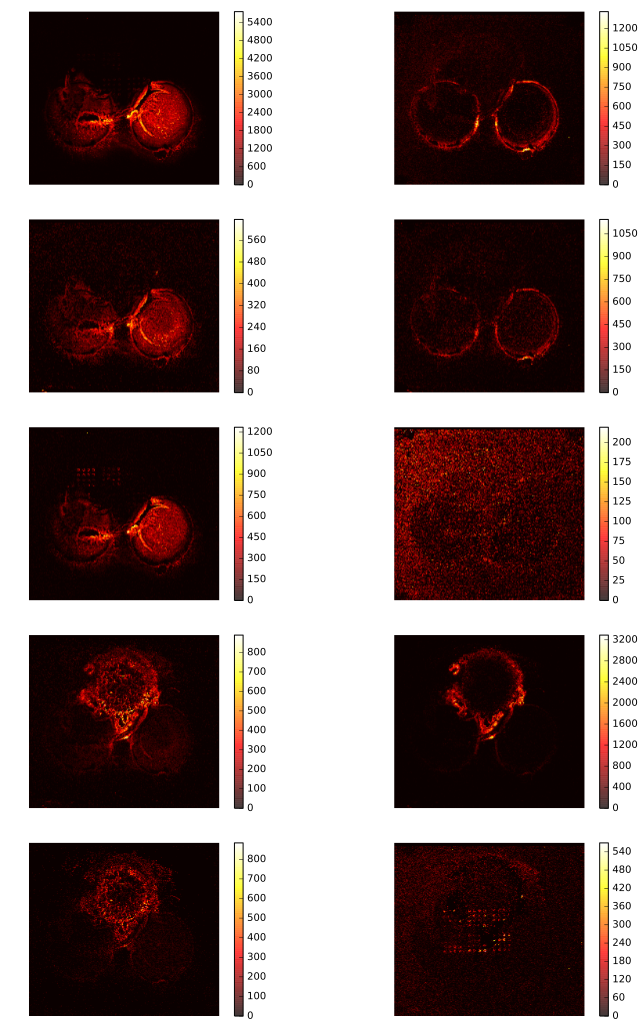

In [17]:
fig = plt.figure(num=None, figsize=(12, 18), dpi=80, facecolor='w', edgecolor='k')
# F=np.zeros((nRows,nCols,3))
cutOff = 100
for i in range(5):
    totalImage = fImage[:,:,i*2+0]+fImage[:,:,i*2+1]
    fluxImage = np.divide(fImage[:,:,i*2+1],totalImage)
    fluxImage[totalImage<cutOff] = 0
    fluxImage[fluxImage>1] = 1
    fluxImage = medfilt2d(fluxImage, kernel_size=3)
    mymap = 'hot'
    plt.subplot(5,2,i*2+1)
    plt.imshow(fImage[:,:,i*2+0],cmap=mymap)#,vmin=0, vmax=1000)
    plt.colorbar()
    plt.axis('off')
    plt.subplot(5,2,i*2+2)
    plt.imshow(fImage[:,:,i*2+1],cmap=mymap)#,vmin=0, vmax=1000)
    plt.axis('off')
    plt.colorbar()
#     plt.subplot(5,3,i*3+3)
#     plt.imshow(fluxImage,cmap=mymap,vmin=0, vmax=1)
#     plt.axis('off')
# plt.colorbar()
plt.show()
#     F[:,:,i] = fluxImage
#     plt.subplot(5,3,i*3+1).imshow((fImage[:,:,i*2+0]+1)**0.5,cmap='CMRmap')
#     plt.axis('off')
#     plt.subplot(5,3,i*3+2).imshow((fImage[:,:,i*2+1]+1)**0.5,cmap='CMRmap')
#     plt.axis('off')
#     plt.subplot(5,3,i*3+3).imshow(fluxImage,cmap='CMRmap')
#     plt.axis('off')
# plt.show()
# fig.savefig('flux images_colorbar.pdf')

/Users/bpb/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


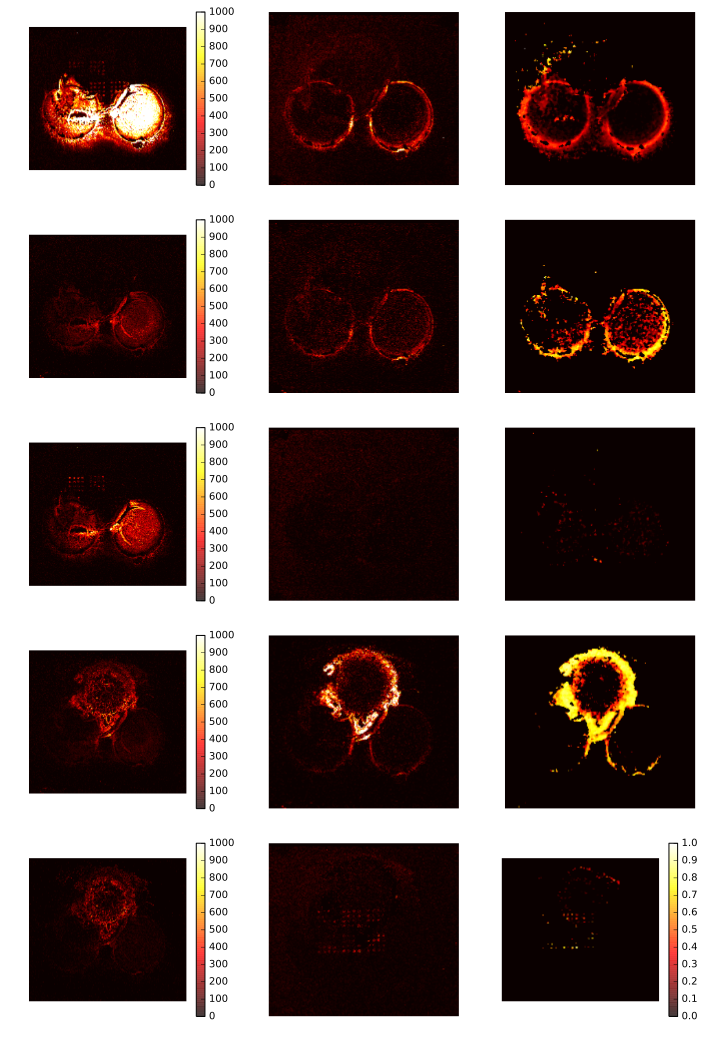

In [9]:
fig = plt.figure(num=None, figsize=(12, 18), dpi=80, facecolor='w', edgecolor='k')
# F=np.zeros((nRows,nCols,3))
cutOff = 100
for i in range(5):
    totalImage = fImage[:,:,i*2+0]+fImage[:,:,i*2+1]
    fluxImage = np.divide(fImage[:,:,i*2+1],totalImage)
    fluxImage[totalImage<cutOff] = 0
    fluxImage[fluxImage>1]=1
    fluxImage = medfilt2d(fluxImage, kernel_size=3)
    mymap = 'hot'
    plt.subplot(5,3,i*3+1)
    plt.imshow(fImage[:,:,i*2+0],cmap=mymap,vmin=0, vmax=1000)
    plt.colorbar()
    plt.axis('off')
    plt.subplot(5,3,i*3+2)
    plt.imshow(fImage[:,:,i*2+1],cmap=mymap,vmin=0, vmax=1000)
    plt.axis('off')
    plt.subplot(5,3,i*3+3)
    plt.imshow(fluxImage,cmap=mymap,vmin=0, vmax=1)
    plt.axis('off')
plt.colorbar()
plt.show()
#     F[:,:,i] = fluxImage
#     plt.subplot(5,3,i*3+1).imshow((fImage[:,:,i*2+0]+1)**0.5,cmap='CMRmap')
#     plt.axis('off')
#     plt.subplot(5,3,i*3+2).imshow((fImage[:,:,i*2+1]+1)**0.5,cmap='CMRmap')
#     plt.axis('off')
#     plt.subplot(5,3,i*3+3).imshow(fluxImage,cmap='CMRmap')
#     plt.axis('off')
# plt.show()
# fig.savefig('flux images_colorbar.pdf')

In [13]:
ions = [[686.6,575.6,503.5],[687.6,576.6,504.5]]
# ions = [[686.6,575.6,708.54],[687.6,576.6,709.54]]
nRows = 222
nCols = 244
# nRows = 250
# nCols = 160
I = np.zeros((nRows,nCols,2,3))
F = np.zeros((nRows,nCols,3))
for i in range(2):
    for j in range(3):
        idx = np.where(abs(mz - ions[i][j])<0.2)
        payload = {'file':filename,
                   'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
        url = 'https://openmsi.nersc.gov/openmsi/qcube'
        r = client.get(url,params=payload)
        data = np.asarray(json.loads(r.content))
        I[:,:,i,j] = np.max(data,2)

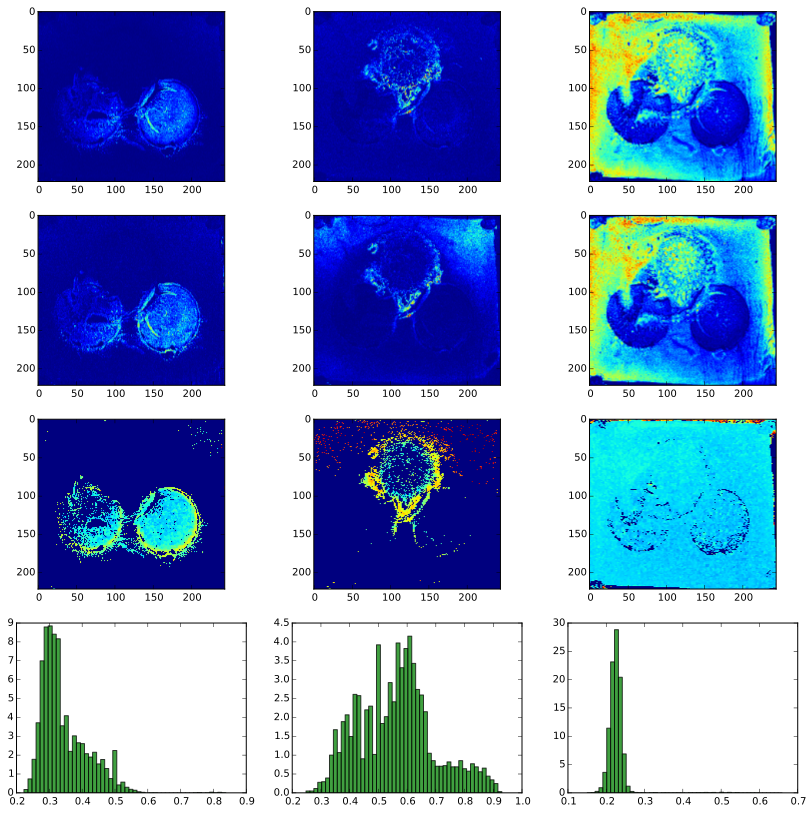

In [14]:
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
c=1
for i in range(2):
    for j in range(3):
        plt.subplot(4,3,c).imshow(I[:,:,i,j])
        c=c+1

for j in range(3):
    temp = I[:,:,0,j].astype(float) + I[:,:,1,j].astype(float)
    fImage = np.divide(I[:,:,1,j].astype(float),temp)
    fImage = medfilt2d(fImage, kernel_size=3)
    idx = np.where(I[:,:,0,j]<50)
    fImage[idx]=0
    idx = np.where(I[:,:,1,j]<50)
    fImage[idx]=0
    
    x = fImage.flatten()
    x = x[x>0]
    
#     idx = np.where(fImage>1.5)
#     fImage[idx]=1.5
    plt.subplot(4,3,c).imshow(fImage, interpolation='nearest')#, cmap=cm.rainbow)
    if sum(x)>0:
        n, bins, patches = plt.subplot(4,3,c+3).hist(x, 50, normed=1, facecolor='green', alpha=0.75)
#     F[:,:,j] = fImage/2
    c=c+1


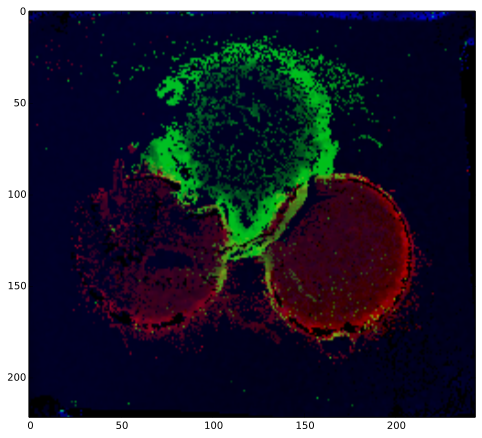

In [6]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
img = plt.imshow(F)

In [70]:
ions = [575.6, 576.6, 577.6, 578.6, 579.6, 580.6, 581.8]
nRows = 222
nCols = 244
# nRows = 250
# nCols = 160

I = np.zeros((nRows,nCols,len(ions)))
for i in range(len(ions)):
    idx = np.where(abs(mz - ions[i])<0.02)
    payload = {'file':filename,
               'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
    url = 'https://openmsi.nersc.gov/openmsi/qcube'
    r = client.get(url,params=payload)
    data = np.asarray(json.loads(r.content))
    I[:,:,i] = np.max(data,2)

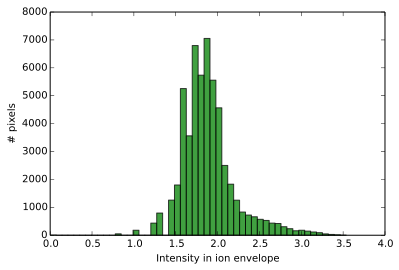

In [71]:
n, bins, patches = plt.hist(np.log10(np.sum(I,2).flatten()+1), 50, facecolor='green', alpha=0.75)
plt.xlabel('Intensity in ion envelope')
plt.ylabel('# pixels')


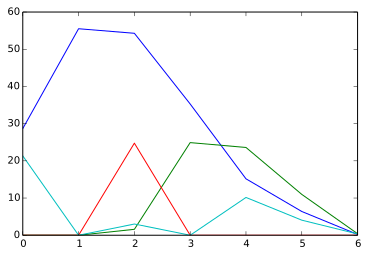

In [119]:
from sklearn.decomposition import NMF
totalIntensity = np.sum(I,2)
dims = totalIntensity.shape
idx = np.argwhere(totalIntensity.flatten() > 2000)
mi,mj = np.unravel_index(idx,dims)
M = np.reshape(I,(I.shape[0]*I.shape[1],I.shape[2]))
nmf = NMF(n_components = 4,tol=0.1)
Xnmf = nmf.fit_transform(np.squeeze(M[idx,:]))
plt.plot(np.transpose(nmf.components_))

In [ ]:
print idx

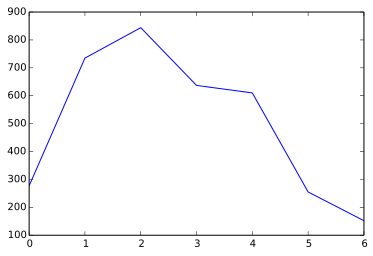

In [30]:
plt.plot(I[42,81,:])

In [120]:
523.4720-137.0230

386.44899999999996